data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp
Fetching data from: https://www.numbeo.com/cost-of-living/rankings.jsp?title=2025 for year 2025
  2025 - Cost of Living Index for Istanbul: 39.8
  2025 - Cost of Living Index for Ankara: 35.5
  2025 - Cost of Living Index for Antalya: 35.5
  2025 - Cost of Living Index for Izmir: 35.1
  2025 - Cost of Living Index for Bursa: 31.4
  2025 - Cost of Living Index for Mersin: 29.2
Fetching data from: https://www.numbeo.com/cost-of-living/rankings.jsp?title=2024 for year 2024
Fetching data from: https://www.numbeo.com/cost-of-living/rankings.jsp?title=2023 for year 2023
  2023 - Cost of Living Index for Eskisehir: 27.5
  2023 - Cost of Living Index for Kocaeli: 27.3
  2023 - Cost of Living Index for Konya: 24.4
  2023 - Cost of Living Index for Adana: 24.3

Gathered Cost of Living Data for Turkey: {'Istanbul': 39.8, 'Ankara': 35.5, 'Antalya': 35.5, 'Izmir': 35.1, 'Bursa': 31.4, 'Mersin': 29.2, 'Eskisehir': 27.5, 'Kocaeli': 27.3, 'K

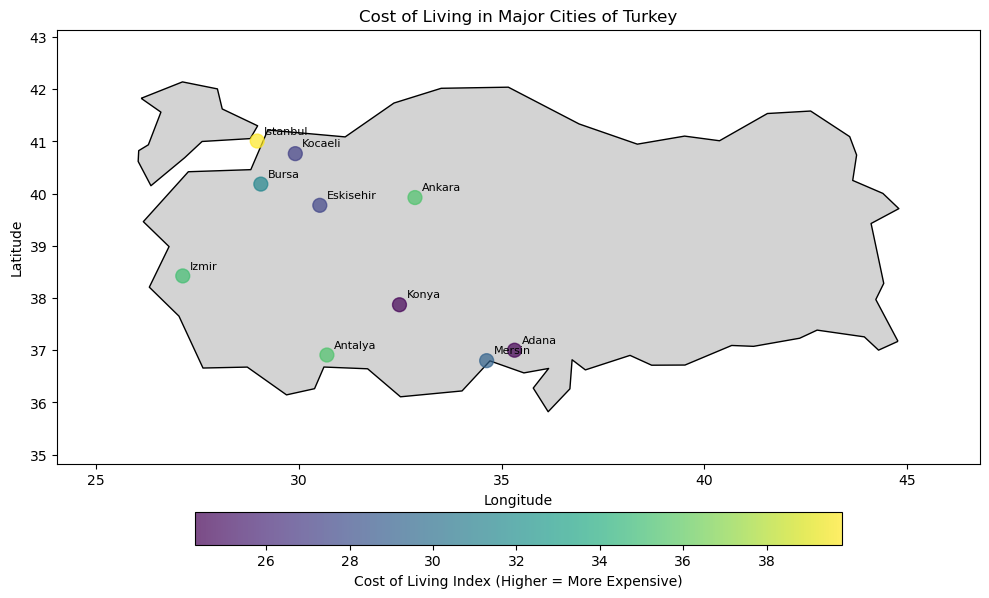

In [1]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Define shapefile path
shapefile_path = 'data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp'
print(shapefile_path)

# Define year and URL
dt_year = dt.datetime.now()
current_year = dt_year.year
base_url = "https://www.numbeo.com/cost-of-living/rankings.jsp?title="
cities_turkey = ["Ankara", "Istanbul", "Izmir", "Bursa", "Adana", "Konya", "Antalya", "Mersin", "Eskisehir", "Kocaeli"]
cost_of_living_data = {}
city_coordinates = {
    "Istanbul": (41.0082, 28.9784),
    "Ankara": (39.9255, 32.8663),
    "Izmir": (38.4237, 27.1428),
    "Bursa": (40.1833, 29.0667),
    "Antalya": (36.9081, 30.6956),
    "Adana": (37.0000, 35.3213),
    "Konya": (37.8714, 32.4846),
    "Mersin": (36.8000, 34.6333),
    "Eskisehir": (39.7767, 30.5206),
    "Kocaeli": (40.7667, 29.9167)
}
# Collect data from current_year back to current_year - 3
for year in range(current_year, current_year - 3, -1):
    base_url_rankings = base_url + str(year)
    print(f"Fetching data from: {base_url_rankings} for year {year}")

    try:
        response = requests.get(base_url_rankings, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the main table containing the city rankings
        rankings_table = soup.find('table', id='t2')  # Assuming 't2' is the ID of the rankings table

        if rankings_table:
            tbody = rankings_table.find('tbody')
            if tbody:
                rows = tbody.find_all('tr', style="width: 100%")
                for row in rows:
                    columns = row.find_all('td')
                    if len(columns) >= 3:  # Ensure there are at least city and COL index columns
                        city_element = columns[1]  # Directly access the city name
                        col_index_element = columns[2]

                        if city_element and col_index_element:
                            city = city_element.get_text(strip=True).split(',')[0].strip()  # Extract city name
                            col_index_text = col_index_element.get_text(strip=True)
                            try:
                                cost_of_living_index = float(col_index_text)
                                if city in cities_turkey and city not in cost_of_living_data:  # Only store data for the cities we are interested in
                                    cost_of_living_data[city] = cost_of_living_index
                                    print(f"  {year} - Cost of Living Index for {city}: {cost_of_living_index}")
                            except ValueError:
                                print(f"  Could not convert COL index for {city} to a number.")
            else:
                print("  Could not find the table body in the rankings table.")
        else:
            print("  Could not find the rankings table with id 't2'.")
        time.sleep(1)
    except requests.exceptions.RequestException as e:
        print(f"  Error fetching data from {base_url_rankings}: {e}")

print("\nGathered Cost of Living Data for Turkey:", cost_of_living_data)

# --- Next Steps: Getting City Coordinates and Creating the Heatmap ---

# 2. Create a Pandas DataFrame
data = []
for city, cost in cost_of_living_data.items():
    if city in city_coordinates:
        lat, lon = city_coordinates[city]
        data.append({'city': city, 'latitude': lat, 'longitude': lon, 'cost_of_living': cost})

df = pd.DataFrame(data)

# 3. Load Turkey Shapefile
try:
    world = gpd.read_file(shapefile_path)  # Using the path you defined
    print(world) #test reading the file, and shows existence
    turkey = world[world['ADMIN'] == 'Turkey']
    # turkey = world[world['name'] == 'Turkey']
except Exception as e:
    print(f"Error loading shapefile: {e}")
    exit()
   
# 4. Create the Heatmap 
if not df.empty and not turkey.empty:  # BREAKING HERE
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    turkey.plot(ax=ax, color='lightgray', edgecolor='black')

    # Create a color map
    cmap = plt.cm.viridis
    norm = plt.Normalize(vmin=df['cost_of_living'].min(), vmax=df['cost_of_living'].max())

    scatter = ax.scatter(df['longitude'], df['latitude'], c=df['cost_of_living'], cmap=cmap, norm=norm, s=100, alpha=0.7)

    cbar = fig.colorbar(scatter, ax=ax, orientation='horizontal', pad=0.05, shrink=0.7)
    cbar.set_label('Cost of Living Index (Higher = More Expensive)')

    # Annotate cities (optional)
    for index, row in df.iterrows():
        ax.annotate(row['city'], (row['longitude'], row['latitude']), textcoords="offset points", xytext=(5,5), ha='left', fontsize=8)

    ax.set_title('Cost of Living in Major Cities of Turkey')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_xlim(turkey.total_bounds[0] - 2, turkey.total_bounds[2] + 2)
    ax.set_ylim(turkey.total_bounds[1] - 1, turkey.total_bounds[3] + 1)
    plt.tight_layout()
    plt.show()
else:
    print("Could not create the heatmap. Ensure cost of living data and the Turkey shapefile were loaded successfully.")
